In [1]:
import cv2
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import json

### Data exploration

In [2]:
glob.glob('./sampleCaptchas/input/*.jpg')[0]

'./sampleCaptchas/input\\input00.jpg'

In [3]:
glob.glob('./sampleCaptchas/input/*.jpg')

['./sampleCaptchas/input\\input00.jpg',
 './sampleCaptchas/input\\input01.jpg',
 './sampleCaptchas/input\\input02.jpg',
 './sampleCaptchas/input\\input03.jpg',
 './sampleCaptchas/input\\input04.jpg',
 './sampleCaptchas/input\\input05.jpg',
 './sampleCaptchas/input\\input06.jpg',
 './sampleCaptchas/input\\input07.jpg',
 './sampleCaptchas/input\\input08.jpg',
 './sampleCaptchas/input\\input09.jpg',
 './sampleCaptchas/input\\input10.jpg',
 './sampleCaptchas/input\\input100.jpg',
 './sampleCaptchas/input\\input11.jpg',
 './sampleCaptchas/input\\input12.jpg',
 './sampleCaptchas/input\\input13.jpg',
 './sampleCaptchas/input\\input14.jpg',
 './sampleCaptchas/input\\input15.jpg',
 './sampleCaptchas/input\\input16.jpg',
 './sampleCaptchas/input\\input17.jpg',
 './sampleCaptchas/input\\input18.jpg',
 './sampleCaptchas/input\\input19.jpg',
 './sampleCaptchas/input\\input20.jpg',
 './sampleCaptchas/input\\input21.jpg',
 './sampleCaptchas/input\\input22.jpg',
 './sampleCaptchas/input\\input23.jpg',

In [4]:
img_arr = []
for file in list(glob.glob('./sampleCaptchas/input/*.jpg')):         
    img  = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.bitwise_not(img)
    img_arr.append(img)

(0.0, 256.0)

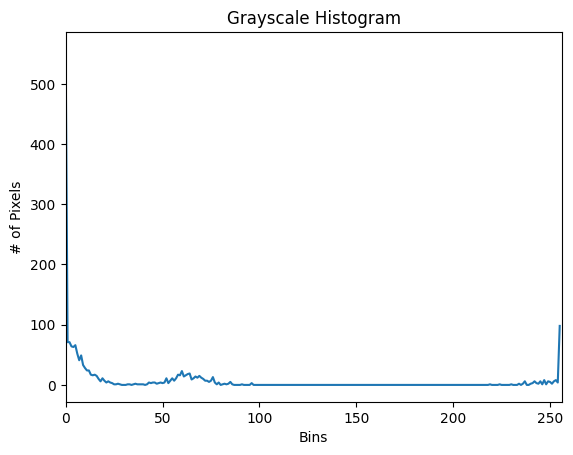

In [5]:
hist = cv2.calcHist(img_arr, [0], None, [256], [0, 256])
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

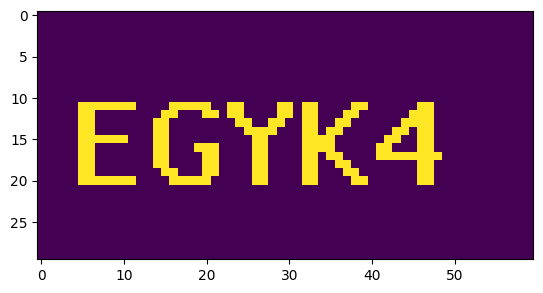

In [24]:
%matplotlib inline

for file in list(glob.glob('./sampleCaptchas/input/*.jpg')):         
    img  = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.bitwise_not(img)
    ret, thresh = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh)
    break

### Evaluate Hu moments of each character

In [22]:
def get_roi_from_image(img):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    roi_list = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        roi_list.append((x, y, w, h))
        left, top = x-1, y-1
        right, bottom = x+w+1, y+h+1
    roi_list.sort(key=lambda x:x[0])
    return roi_list

def get_moments_from_roi(roi):
    (x, y, w, h) = roi
    left, top = x-1, y-1
    right, bottom = x+w+1, y+h+1
    roi_image = thresh[top:top+h+2, left:left+w+2]
    moments = cv2.moments(roi_image) 
    # Calculate Hu Moments 
    huMoments = cv2.HuMoments(moments)
    huMoments = huMoments.flatten()
    return huMoments

In [10]:
hu_moment_dict = dict()
for i in range(25):
    if i == 21:
        continue
    input_image_path = f"./sampleCaptchas/input/input{i:02d}.jpg"
    output_text_path = f"./sampleCaptchas/output/output{i:02d}.txt"
    with open(output_text_path, 'r') as file:
        for line in file:
            text_answer = line
    img  = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.bitwise_not(img)
    ret, thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
    roi_list = get_roi_from_image(thresh)
    # Calculate Moments 
    for i in range(len(roi_list)):
        roi = roi_list[i]
        hu_moments = get_moments_from_roi(roi)
        character = text_answer[i]
        if character not in hu_moment_dict:
            hu_moment_dict[character] = [np.array(hu_moments)]
        else:
            hu_moment_dict[character].append(np.array(hu_moments))

### Verify no outlier shapes

In [11]:
import itertools
for k,v in hu_moment_dict.items():
    size = len(hu_moment_dict[k])
    combi = itertools.combinations([i for i in range(size)], 2)
    for c in combi:
        val = np.linalg.norm(hu_moment_dict[k][c[0]] - hu_moment_dict[k][c[1]])
        assert(val == 0)

### Get mean of Hu moments for each character

In [12]:
hu_moment_dict_mean = dict()
for k,v in hu_moment_dict.items():
    hu_moment_dict_mean[k] = np.mean(hu_moment_dict[k], axis=0).tolist()

In [13]:
hu_moment_dict_mean

{'E': [0.0016687419930316927,
  6.904270649956374e-07,
  2.3576347226255613e-10,
  2.0902198491516978e-10,
  -4.39080274684005e-20,
  -1.66035812051066e-13,
  1.5004223640818668e-20],
 'G': [0.0017030909653261734,
  1.2299393268551143e-07,
  2.1980783626634353e-10,
  8.502407729769176e-11,
  -2.583010232722635e-21,
  -1.913729555480598e-14,
  -1.1332797112362608e-20],
 'Y': [0.0016277939747327507,
  4.0627597618495554e-07,
  3.9321698303091264e-09,
  5.257624410225622e-12,
  7.559628793839548e-22,
  3.351198317842321e-15,
  -3.349589222722705e-35],
 'K': [0.0013235294117647054,
  8.650519031141867e-08,
  7.632810909831063e-11,
  1.1402100248019238e-10,
  -1.0637009187208395e-20,
  -3.353558896476246e-14,
  0.0],
 '4': [0.001088984165094609,
  6.137236042794835e-08,
  6.447790088245599e-10,
  3.5410782674574492e-12,
  -1.6824362483167154e-22,
  5.966874975733676e-16,
  1.7995191933223268e-23],
 'R': [0.0012286370487630438,
  2.1594910822996e-08,
  5.595574714592607e-12,
  2.108658902377

In [14]:
with open("./hu_moments_values.json", "w") as outfile: 
    json.dump(hu_moment_dict_mean, outfile)

### Inference

In [15]:
def get_char_nearest_hu(hu_moments, hu_moment_dict_mean):
    nearest_dist = np.Inf
    char = None
    for k,v in hu_moment_dict.items():
        dist = np.linalg.norm(hu_moments - hu_moment_dict_mean[k])
        if dist < nearest_dist:
            char = k
            nearest_dist = dist
    return char

In [16]:
input_image_path = f"./sampleCaptchas/input/input100.jpg"

img  = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.bitwise_not(img)
ret, thresh = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
get_roi_from_image(thresh)

hu_moment_dict_mean = json.load(open('./hu_moments_values.json'))

# Calculate Moments 
for i in range(len(roi_list)):
    roi = roi_list[i]
    hu_moments = get_moments_from_roi(roi)
    print(get_char_nearest_hu(hu_moments, hu_moment_dict_mean))

Y
M
B
1
Q
